In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import numpy as np
import pickle
from helpers_train import load_train_dataset, train_data_preprocessing

# import importlib
# import helpers
# importlib.reload(helpers)

In [30]:
folder_path = "processed_data/train"
data_df = load_train_dataset(folder_path)
data_df.sample(10)

Loading Data: 100%|██████████| 5/5 [00:00<00:00, 12.74file/s]


,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,label
32145,0.1400,0.2740,-0.9620,0.3660,-0.0610,0.1830,163.3610,-8.3720,-97.6410,lying
56793,0.0450,0.4100,-0.7900,-40.6490,-63.7210,59.3870,177.0890,7.2340,-17.3690,walking
41023,-0.8430,0.0960,-0.6040,-0.0610,1.6480,-0.6100,169.8820,51.8880,-5.0260,sitting
25533,0.1460,0.2550,-0.9620,-0.3660,0.1830,0.4270,164.7340,-8.8880,-76.7180,lying
35582,-0.3520,-0.0700,-1.0050,-37.2920,12.6950,-90.9420,-177.2200,20.7480,10.9370,climbing
35531,0.2393,-0.5444,-0.8481,2.8076,-17.4561,-18.3716,-147.4695,-13.0573,87.8357,running
11436,-0.5957,0.2974,0.6382,16.9067,-64.5752,26.1841,52.8882,40.9900,-41.3416,walking
20170,0.0580,0.1980,-0.9860,-0.7320,0.1220,0.3660,168.1840,-3.7300,-43.8680,lying
23454,-0.8020,-0.2260,-0.1240,-13.5500,5.3100,-21.7290,-156.8130,58.8260,-26.2300,climbing
48807,-0.2610,-0.1330,-0.2850,-4.5170,4.0280,-47.3020,166.5360,21.0660,56.2500,walking


In [31]:
data_df.shape

(285905, 10)

In [32]:
features = data_df.iloc[:, :-1]
labels = data_df['label']

print("Features shape: ", features.shape)
print("Labels shape: ", labels.shape)

Features shape:  (285905, 9)
Labels shape:  (285905,)


In [33]:
features

,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ
1,-0.4067,-0.7988,-0.5088,-0.4883,1.5869,1.7090,-122.5250,24.3237,158.3789
2,-0.4067,-0.7988,-0.5088,-0.4883,1.5869,0.7324,-122.5305,24.3182,158.3624
3,-0.4175,-0.7764,-0.4868,-0.4883,1.5869,0.7324,-122.5360,24.3073,158.3405
4,-0.4175,-0.7764,-0.4868,-1.5869,2.0752,-0.4272,-122.5525,24.2908,158.3240
5,-0.4121,-0.7817,-0.4692,-1.5869,2.0752,-0.4272,-122.5690,24.2743,158.3075
...,...,...,...,...,...,...,...,...,...
59098,0.4560,-2.0970,-12.3740,19.7140,-124.5730,-36.9870,156.8900,-30.4600,-98.0260
59099,0.4560,-0.3770,-1.7610,69.1530,-115.3560,-26.9170,157.8680,-29.2350,-98.2180
59100,0.3790,-0.3770,-1.7610,69.1530,-115.3560,-26.9170,158.8240,-28.0040,-98.3770
59101,0.3790,-0.3270,-1.7650,105.5300,-127.2580,-11.6580,160.2190,-26.7190,-98.7070


In [34]:
features_scaled, labels_categorical = train_data_preprocessing(
    features, labels)
print("Features shape: ", features_scaled.shape)
print("Labels shape: ", labels_categorical.shape)

Features shape:  (285905, 9)
Labels shape:  (285905, 5)


In [69]:
# Sliding window parameters
window_size = 128
stride = 64

# Generate sequences using sliding windows
sequences = []
labels = []

for i in range(0, len(features_scaled) - window_size + 1, stride):
    window = features_scaled[i:i+window_size]
    label = labels_categorical[i+window_size-1]
    if len(window) == window_size:
        sequences.append(window)
        labels.append(label)


X_sliding = np.array(sequences)
y_sliding = np.array(labels)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sliding, y_sliding, test_size=0.2, random_state=42)

In [71]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3572, 128, 9)
X_test shape:  (894, 128, 9)
y_train shape:  (3572, 5)
y_test shape:  (894, 5)


In [104]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout, Dense


class CNN1D:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_model(self):
        model = Sequential()
        model.add(Conv1D(filters=256, kernel_size=3,
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(2048, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.3))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

        return model

In [105]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

model = CNN1D(input_shape, num_classes).build_model()

# model.summary()

In [106]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

callbacks_list = [checkpoint, early_stop]

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=callbacks_list, verbose=1)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.6249 - accuracy: 0.3614
Epoch 1: val_loss improved from inf to 1.07988, saving model to model_checkpoint.h5
14/14 [==============================] - 6s 375ms/step - loss: 1.6249 - accuracy: 0.3614 - val_loss: 1.0799 - val_accuracy: 0.4787
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.9530 - accuracy: 0.5983
Epoch 2: val_loss improved from 1.07988 to 0.91977, saving model to model_checkpoint.h5
14/14 [==============================] - 5s 373ms/step - loss: 0.9530 - accuracy: 0.5983 - val_loss: 0.9198 - val_accuracy: 0.7304
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7492
Epoch 3: val_loss improved from 0.91977 to 0.59383, saving model to model_checkpoint.h5
14/14 [==============================] - 5s 363ms/step - loss: 0.6756 - accuracy: 0.7492 - val_loss: 0.5938 - val_accuracy: 0.7729
Epoch 4/50
14/14 [==============================] - ETA: 0s - los

Prediction


In [13]:
import importlib
import helpers_test
import pandas as pd
import numpy as np
import keras
import pickle
importlib.reload(helpers_test)

<module 'helpers_test' from 'e:\\THWS\\Project Moduls\\Dog-Activity-Recognition\\helpers_test.py'>

In [14]:
from helpers_test import make_prediction, read_file, test_data_preprocessing, load_test_dataset, ensemble_voting

In [15]:
# Process Raw Data
file_path = "processed_data/test/test1.csv"
test_data_df = read_file(file_path)
test_data_df

,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,labels
0,-0.515,0.024,-0.869,20.569,-4.700,28.137,175.567,28.460,96.081,climbing
1,-0.504,0.024,-0.869,20.569,-4.700,28.137,175.616,28.488,95.757,climbing
2,-0.504,0.024,-0.875,22.888,-5.432,26.062,175.682,28.526,95.444,climbing
3,-0.493,0.024,-0.875,22.888,-5.432,26.062,175.770,28.564,95.147,climbing
4,-0.493,0.048,-0.879,24.292,-4.700,22.949,175.875,28.603,94.861,climbing
...,...,...,...,...,...,...,...,...,...,...
16179,-0.460,0.012,-0.893,1.526,2.686,6.653,-179.594,25.598,-0.687,walking
16180,-0.464,0.012,-0.893,1.526,2.686,6.653,-179.599,25.576,-0.758,walking
16181,-0.464,0.010,-0.889,-1.526,0.366,3.845,-179.615,25.565,-0.813,walking
16182,-0.450,0.010,-0.889,-1.526,0.366,3.845,-179.643,25.565,-0.851,walking


In [4]:
# For the file which contains of labels
org_labels = test_data_df['labels']
test_data_df = test_data_df.iloc[:, :-1]

In [5]:
scaled_data = test_data_preprocessing(test_data_df)
# scaled_data

In [6]:
scaled_df = pd.DataFrame(scaled_data, columns=test_data_df.columns)
# scaled_df

In [7]:
# Create a sliding window of 10 seconds for the data
window_size = 128
stride = 64

# Generate sequences using sliding windows
sequences = []
labels = []
for i in range(len(scaled_df) - window_size):
    window = scaled_df[i:i+window_size]
    if len(window) == window_size:
        sequences.append(window)

X_sliding = np.array(sequences)

In [16]:
# Make predictions
model = keras.models.load_model("utils/model80.h5")

all_actions, most_occurred_pred = make_prediction(model, X_sliding)


print("All actions: ", all_actions)
print("Most occurred prediction: ", most_occurred_pred)

502/502 [==============================] - 12s 24ms/step
All actions:  ['sitting' 'sitting' 'sitting' ... 'climbing' 'climbing' 'climbing']
Most occurred prediction:  walking


In [21]:
# model_76 = keras.models.load_model('utils/model76.h5')
model_77 = keras.models.load_model('utils/model77.h5')
model_78 = keras.models.load_model('utils/model78.h5')
model_78_2 = keras.models.load_model('utils/model78_2.h5')
model_79 = keras.models.load_model('utils/model79.h5')
model_80 = keras.models.load_model('utils/model80.h5')

models = [model_77, model_78, model_78_2, model_79, model_80]

# Make predictions
all_actions, most_occurred_pred = ensemble_voting(models, X_sliding)
print("All actions: ", all_actions)
print("Most occurred prediction: ", most_occurred_pred)

502/502 [==============================] - 11s 22ms/step
All actions:  ['sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbing', 'climbi

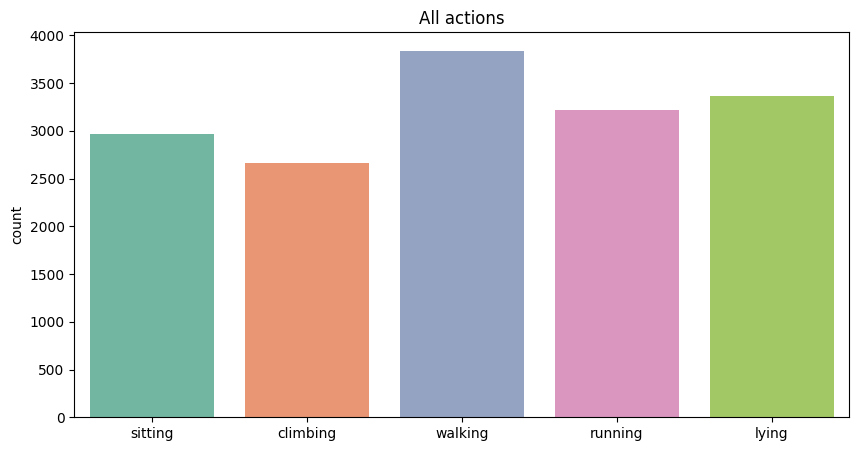

In [126]:
# Draw a freq chart for all actions, different colors for each action
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=all_actions, palette="Set2")
plt.title('All actions')
plt.show()

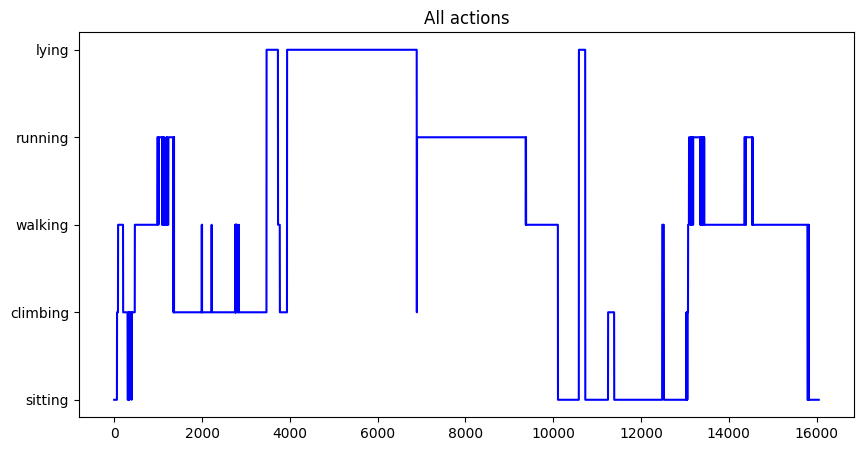

In [127]:
# Draw a line chart for all actions, different colors for each action
plt.figure(figsize=(10, 5))
plt.plot(all_actions, color='blue')
plt.title('All actions')
plt.show()

In [128]:
len(all_actions)

16048

In [129]:
# Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(org_labels[:16048], all_actions)
# accuracy_score(org_labels, all_actions)

0.7934322033898306

In [119]:
# model.save("utils/model78_2.h5")

In [144]:
from sklearn.metrics import classification_report

# Assuming org_labels is a list of original labels and all_actions is the predicted labels
report = classification_report(org_labels[:16048], all_actions)

# Print and save classification report to a file
print(report)

with open('utils/classification_report.txt', 'w') as file:
    file.write(report)

              precision    recall  f1-score   support

    climbing       0.88      0.67      0.76      3499
       lying       0.95      0.91      0.93      3492
     running       0.74      0.76      0.75      3131
     sitting       0.88      0.87      0.87      2984
     walking       0.58      0.76      0.66      2942

    accuracy                           0.79     16048
   macro avg       0.80      0.79      0.79     16048
weighted avg       0.81      0.79      0.80     16048



<Figure size 1000x600 with 0 Axes>

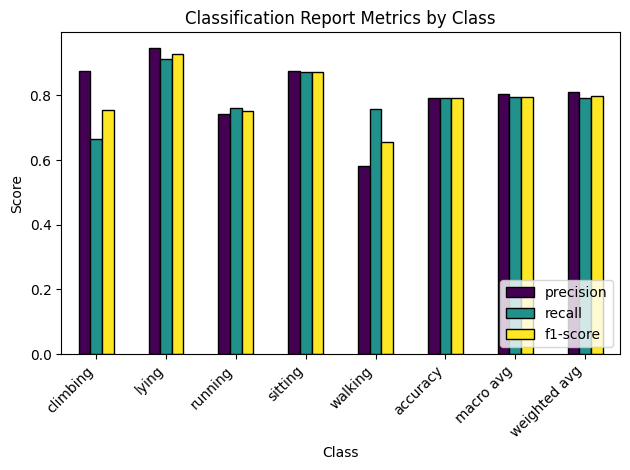

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

# Assuming org_labels is a list of original labels and all_actions is the predicted labels
report = classification_report(
    org_labels[:16048], all_actions, target_names=label_encoder.classes_, output_dict=True)

# Convert the classification report to a DataFrame for better visualization
df_report = pd.DataFrame(report).transpose()

# Plot a bar chart for precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
df_report[['precision', 'recall', 'f1-score']
          ].plot(kind='bar', colormap='viridis', edgecolor='black')
plt.title('Classification Report Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

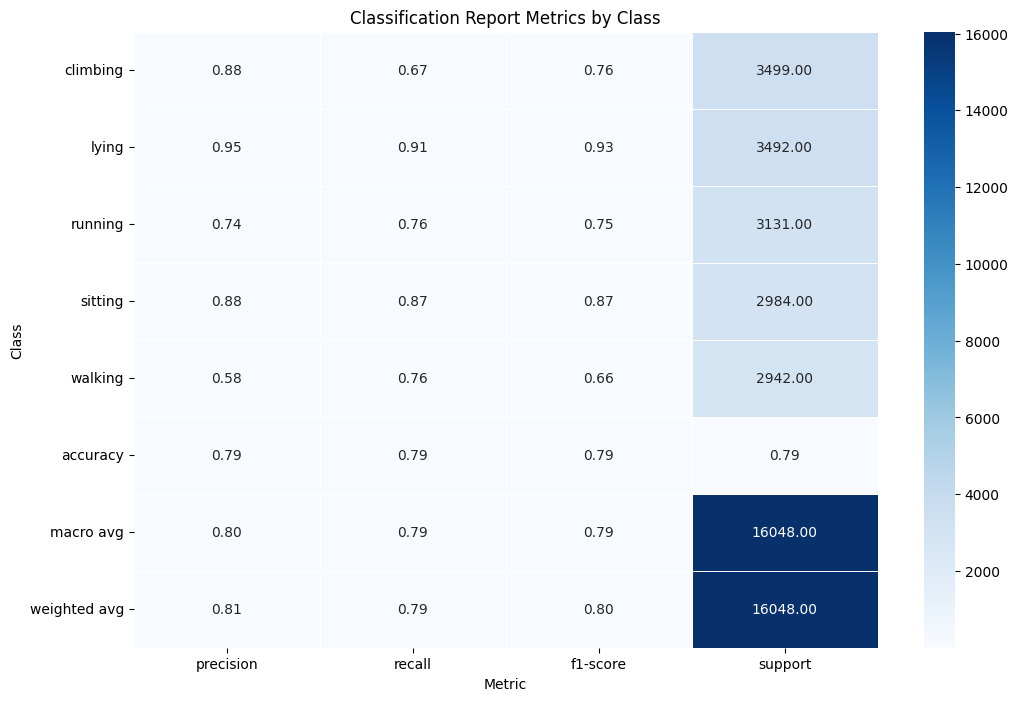

In [29]:
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Assuming org_labels is a list of original labels and all_actions is the predicted labels
report = classification_report(
    org_labels[:16048], all_actions, target_names=label_encoder.classes_, output_dict=True)

# Convert the classification report to a DataFrame for better visualization
df_report = pd.DataFrame(report).transpose()

# Plot a Seaborn heatmap for precision, recall, F1-score, and support for each class
plt.figure(figsize=(12, 8))

# Rotate the y-axis (Class) tick labels
ax = sns.heatmap(df_report[['precision', 'recall', 'f1-score', 'support']],
                 annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

plt.title('Classification Report Metrics by Class')
plt.xlabel('Metric')
plt.ylabel('Class')
plt.show()

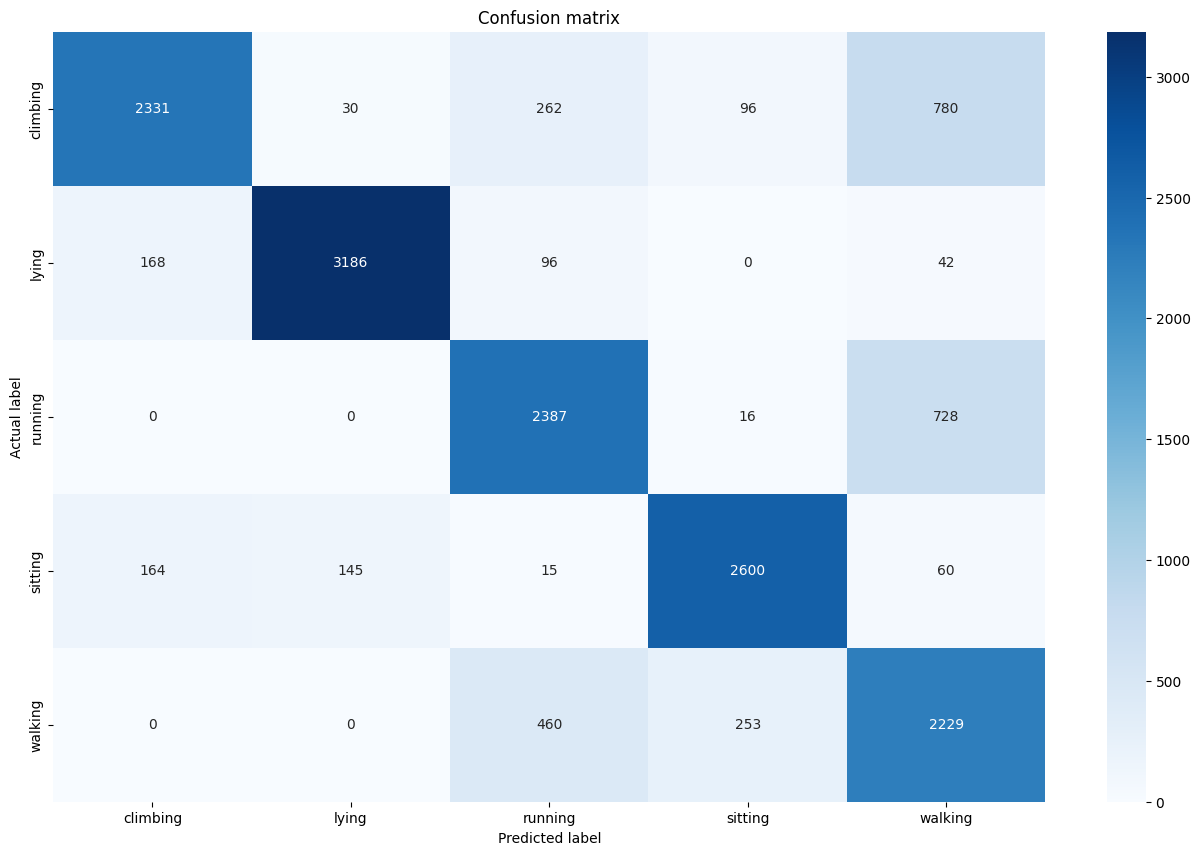

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming org_labels is a list of original labels and all_actions is the predicted labels
cm = confusion_matrix(org_labels[:16048], all_actions)

# Get unique class names from both actual and predicted labels
class_names = sorted(set(org_labels[:16048]) | set(all_actions))

plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()